In [24]:
import os
import glob
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from scipy.ndimage import gaussian_filter1d
from scipy import stats
import statsmodels.formula.api as smf

sns.set_context('poster')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# import Python3_OpenOE_AC_map_functions_v1_08_30s as oem
import mz_LFP_functions as mz_LFP

import Python3_icsd as icsd 
import scipy.signal as sg
import quantities as pq

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
plt.rcdefaults()

# # for publication quality plots
# def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
#     sns.set_style("white")
#     sns.set_palette(pal)
#     sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
#     sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
#     # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
#     plt.rcParams['axes.linewidth'] = 2.5

# rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
#     'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
#     #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
#     'axes.linewidth':2.5, 'lines.linewidth': 2.5,
#     'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# # to restore the defaults, call plt.rcdefaults() 

# #set_pub_bargraphs()
# set_pub_plots()

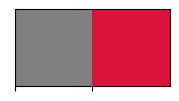

In [7]:
pal=sns.blend_palette(['gray','crimson'],2)
sns.palplot(pal)
sns.set_palette(pal)

# Load some necessary variables

In [8]:
insert_depth = 3100  #change this as appropriate

sp_bw_ch = 20/2

surface_ch = np.round(insert_depth/sp_bw_ch)
V1_hip_ch = np.round((insert_depth-1100)/sp_bw_ch)
Hip_thal_ch = np.round((insert_depth-1100-1200)/sp_bw_ch)

CA1_DG_ch = np.round((insert_depth-1100-600)/sp_bw_ch)

print(surface_ch, V1_hip_ch, Hip_thal_ch, CA1_DG_ch)

310.0 200.0 80.0 140.0


In [9]:
samples_tr = 7350 #this is based on the shortest #samples in a trial
sr = 2500
n_chan = 384
rec_length = 3.0 #how long is the arduino triggered?

---

# First, load in the .npy arrays and CC_ls
These were creaded and saved using the "1_saving_LFP_arrays" jupyter notebook

In [10]:
all_pre_arr = np.load(r"D:\pre_alltr.npy")
all_post_arr = np.load(r"D:\post_alltr.npy")
all_novel_arr = np.load(r"D:\novel_alltr.npy")

In [15]:
pkl_file = r"D:\pre_alltr_et_ls"

open_file = open(pkl_file, "rb")
et_ls_pre = pickle.load(open_file)
open_file.close()

print(et_ls_pre)

['et311', 'et323', 'et3112']


In [14]:
pkl_file = r"D:\post_alltr_et_ls"

open_file = open(pkl_file, "rb")
et_ls_post = pickle.load(open_file)
open_file.close()

print(et_ls_post)

['et1', 'et200', 'et20', 'et2', 'et10', 'et3', 'et30', 'et383', 'et3112', 'et3232', 'et3832', 'et311', 'et323']


In [16]:
pkl_file = r"D:\novel_alltr_et_ls"

open_file = open(pkl_file, "rb")
et_ls_novel = pickle.load(open_file)
open_file.close()

print(et_ls_novel)

['CC082263HP1', 'CC082263HP2', 'CC082263HP3', 'CC084621HP1', 'CC084621HP2', 'CC067489HP2', 'CC067489HP3', 'CC082260HP2', 'CC082260HP3', 'CC082260HP4']


---

# Test the shape of the arrays

In [19]:
print('Pre training: {}'.format(all_pre_arr.shape))
print('Post training: {}'.format(all_post_arr.shape))
print('Novel training: {}'.format(all_novel_arr.shape))

Pre training: (3, 28, 384, 7350)
Post training: (13, 28, 384, 7350)
Novel training: (10, 48, 384, 7350)


---

# Plot the individual trials for each mouse

In [99]:
colormap='jet'
print(surface_ch, V1_hip_ch, Hip_thal_ch, CA1_DG_ch)

report_directory = r'C:\'
save_plots = 1

310.0 200.0 80.0 140.0


In [1]:
# for idx, mouse in enumerate(all_pre_arr):
#     mouse_et = et_ls_pre[idx]
#     tot_trials = mouse.shape[0]
#     fig,ax = plt.subplots(tot_trials,1, figsize=(7,tot_trials*7))
#     for idx2, trials in enumerate(mouse):
#         lfp_plot_data = trials * 1E-3 * pq.mV #helps to keep the colorbar tidy and clean
#         im = ax[idx2].imshow(lfp_plot_data, origin='lower', 
#                        vmin=-abs(lfp_plot_data).max(), vmax=abs(lfp_plot_data).max(), 
#                        cmap=colormap, interpolation='nearest',
#                        aspect='auto')
#         ax[idx2].axvspan((0.5*2500),(0.7*2500), color='grey', alpha=0.2)
#         ax[idx2].axhline(surface_ch, color='grey', alpha=0.5)
# #         ax[idx2].axhline(V1_hip_ch, color='grey', alpha=0.5)
# #         ax[idx2].axhline(Hip_thal_ch, color='grey', alpha=0.5)
#         ax[idx2].axhline()
#         ax[idx2].set_xticks(ticks=[0, 1*2500, 2*2500])
#         ax[idx2].set_xticklabels(labels=[0,1,2])
#         ax[idx2].set_ylabel('Channel #')
# #         ax[idx2].set_xlabel('Time (s)')
#         ax[idx2].set_title('Pre: {0}, Trial {1}'.format(mouse_et, idx2))
#         cb = plt.colorbar(im, ax=ax[idx2], aspect=50, shrink=0.8)
#         cb.set_label('LFP (%s)' % lfp_plot_data.dimensionality.string)
#     #Change this to save the plots to an appropriate spot
#     if save_plots == 1:
#         plt.savefig(report_directory+'pre_'+mouse_et+'_lfp_all_trials.pdf', bbox_inches='tight')
#     plt.show()
